# Exploración de hiperparámetros

In [65]:
import pandas as pd
import numpy as np
pd.set_option("max_rows", None)
from os import listdir
from os.path import isfile, join
import re
import os
import sys
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})
tab_c = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink',
         'tab:gray','tab:olive','tab:cyan']

from MCMC_steiner_tree import Annealing, pre_pros, plot_graph_by_edges, Trans, weight, Annealing, read_stp, check_steiner_tree

In [2]:
root = {
    "main": "",  # "/Proyecto Sim. Est.",
    "data":"I080/",
    "data_I320":"/I320/",
}

## Importando resultados

In [3]:
f = open('gridsearch/gridsearch.json')
grid_search = json.load(f)
print(grid_search)
f.close()

{'a': [0.5, 0.875, 1.25, 1.625, 2.0], 'b': [0.0, 0.25, 0.5, 0.75, 1.0]}


In [4]:
f = open('gridsearch/params.json')
params = json.load(f)
print(params)
f.close()

{'nf': 3000, 'save_rate': 5, 'repeat': 10}


In [5]:
stp_names = ['i080-001.stp', 'i080-011.stp', 'i080-021.stp', 'i080-031.stp', 'i080-041.stp', 'i080-101.stp',
             'i080-111.stp', 'i080-121.stp', 'i080-131.stp', 'i080-141.stp', 'i080-201.stp', 'i080-211.stp',
             'i080-221.stp', 'i080-231.stp', 'i080-241.stp', 'i080-301.stp', 'i080-311.stp', 'i080-321.stp',
             'i080-331.stp', 'i080-341.stp']

In [6]:
df_opt = pd.read_excel('Testset_I320.xlsx', sheet_name="I080")
df_opt = df_opt.set_index("Name")
df_opt.head()

,|V|,|E|,|T|,DC,time,Opt
Name,,,,,,
i080-001,80.0,120.0,6.0,P,s,1787.0
i080-002,80.0,120.0,6.0,P,s,1607.0
i080-003,80.0,120.0,6.0,P,s,1713.0
i080-004,80.0,120.0,6.0,P,s,1866.0
i080-005,80.0,120.0,6.0,P,s,1790.0


In [7]:
with open('gridsearch/UNIFORMS.pickle', 'rb') as handle:
    uniforms = pickle.load(handle)

In [10]:
methods = ['BFS_node','DFS_node']
a_values = grid_search['a']
b_values = grid_search['b']
len_U = len(uniforms)

In [40]:
class grafo_resultado(object):
    def __init__(self,name,len_U,df=df_opt,folder=root['main']+root['data']):
        name = name if not '.stp' in name else name.replace('.stp','')
        df_edges_G, terminals = read_stp(folder+name+'.stp')
        _, _, dic_edges, _ = pre_pros(df_edges_G)
        self.id = name
        self.terminals = terminals
        self.dic_edges = dic_edges
        self.opt = df['Opt'][name]
        self.size = int(df['|V|'][name])
        self.length = int(df['|E|'][name])
        self.difficulty = df['DC'][name]
        self.time = df['time'][name]
        self._results_loaded = False
        self._weights_computed = False
        self.len_U = len_U
        self.density = 2*self.length/(self.size*(self.size-1))
    
    @staticmethod
    def load_cm_path(path):
        with open(path, 'rb') as handle:
            return pickle.load(handle)
    
    def get_results(self,methods,a_values=grid_search['a'],b_values=grid_search['b']):
        results = {}
        for m in methods:
            results[m] = {}
            for i, a in enumerate(a_values):
                results[m][a] = {}
                for j, b in enumerate(b_values):
                    results[m][a][b] = {}
                    for l in range(self.len_U):
                        file = 'gridsearch/{}/{}_ixa={}_ixb={}_ixu={}_CM.pickle'.format(self.id,m,i,j,l)
                        results[m][a][b][l] = self.load_cm_path(file)
        self.results = results
        self._results_loaded = True
    
    def compute_weight_cm(self):
        weight_cm = {}
        weight_avg = {}
        for m in methods:
            weight_cm[m] = {}
            weight_avg[m] = {}
            for a in a_values:
                weight_cm[m][a] = {}
                weight_avg[m][a] = {}
                for b in b_values:
                    weight_cm[m][a][b] = {}
                    for l in range(self.len_U):
                        weight_cm[m][a][b][l] = [weight(x, self.dic_edges) for x in self.results[m][a][b][l]]
                    weight_avg[m][a][b] = self.avg_weights(weight_cm[m][a][b])
        self.weight_cm = weight_cm
        self.weight_avg = weight_avg
        self._weights_computed = True
        self.compute_weight_final()
    
    @staticmethod
    def avg_weights(cm_unifs):
        N = int(params['nf']/params['save_rate'])+2
        weights_avg = np.zeros(N)
        for l in cm_unifs.keys():
            weights_avg += np.array(cm_unifs[l])
        weights_avg = weights_avg/len(cm_unifs)
        return list(weights_avg)
    
    def compute_weight_final(self):
        weight_final = {}
        for m in methods:
            weight_final[m] = {}
            for a in a_values:
                weight_final[m][a] = {}
                for b in b_values:
                    weight_final[m][a][b] = {}
                    for l in range(self.len_U):
                        if self._weights_computed:
                            weight_final[m][a][b][l] = self.weight_cm[m][a][b][l][-1]
                        else:
                            x = self.results[m][a][b][l][-1]
                            weight_final[m][a][b][l] = weight(x, self.dic_edges)
        self.weight_final = weight_final

In [41]:
%%time
grafo = 'i080-001'
grafo_result = grafo_resultado(grafo,len_U)
grafo_result.get_results(methods)
# grafo_result.results['BFS_node'][0.875][0.25]

CPU times: user 146 ms, sys: 8.35 ms, total: 155 ms
Wall time: 148 ms


In [42]:
%%time
grafo_result.compute_weight_cm()

CPU times: user 1.84 s, sys: 0 ns, total: 1.84 s
Wall time: 1.84 s


In [66]:
def plot_a(grafo_result,a_values,b,unif='mean',log=False):
    # unif: 'mean' (str) or index (int)
    fig, ax = plt.subplots(1, 1, figsize=(25*2, 18))
    N = len(grafo_result.weight_avg[methods[0]][a_values[0]][b_values[0]])
    Ns = [i*params['save_rate'] for i in range(N)]
    for i, a in enumerate(a_values):
        if unif=='mean':
            values_dfs = grafo_result.weight_avg['DFS_node'][a][b][1:]
            values_bfs = grafo_result.weight_avg['BFS_node'][a][b][1:]
        else:
            values_dfs = grafo_result.weight_cm['DFS_node'][a][b][unif][1:]
            values_bfs = grafo_result.weight_cm['BFS_node'][a][b][unif][1:]
        ax.plot(Ns[1:], values_dfs, color=tab_c[i], label='DFS_node a={}'.format(a), linestyle='dotted')
        ax.plot(Ns[1:], values_bfs, color=tab_c[i], label='BFS_node a={}'.format(a), linestyle='solid')
    ax.legend()
    ax.axhline(y=grafo_result.opt, color="limegreen")
    ax.set_title('Pesos para distintos valores de a, grafo = {}, b={}'.format(grafo_result.id,b))
    if log:
        ax.set_yscale('log')

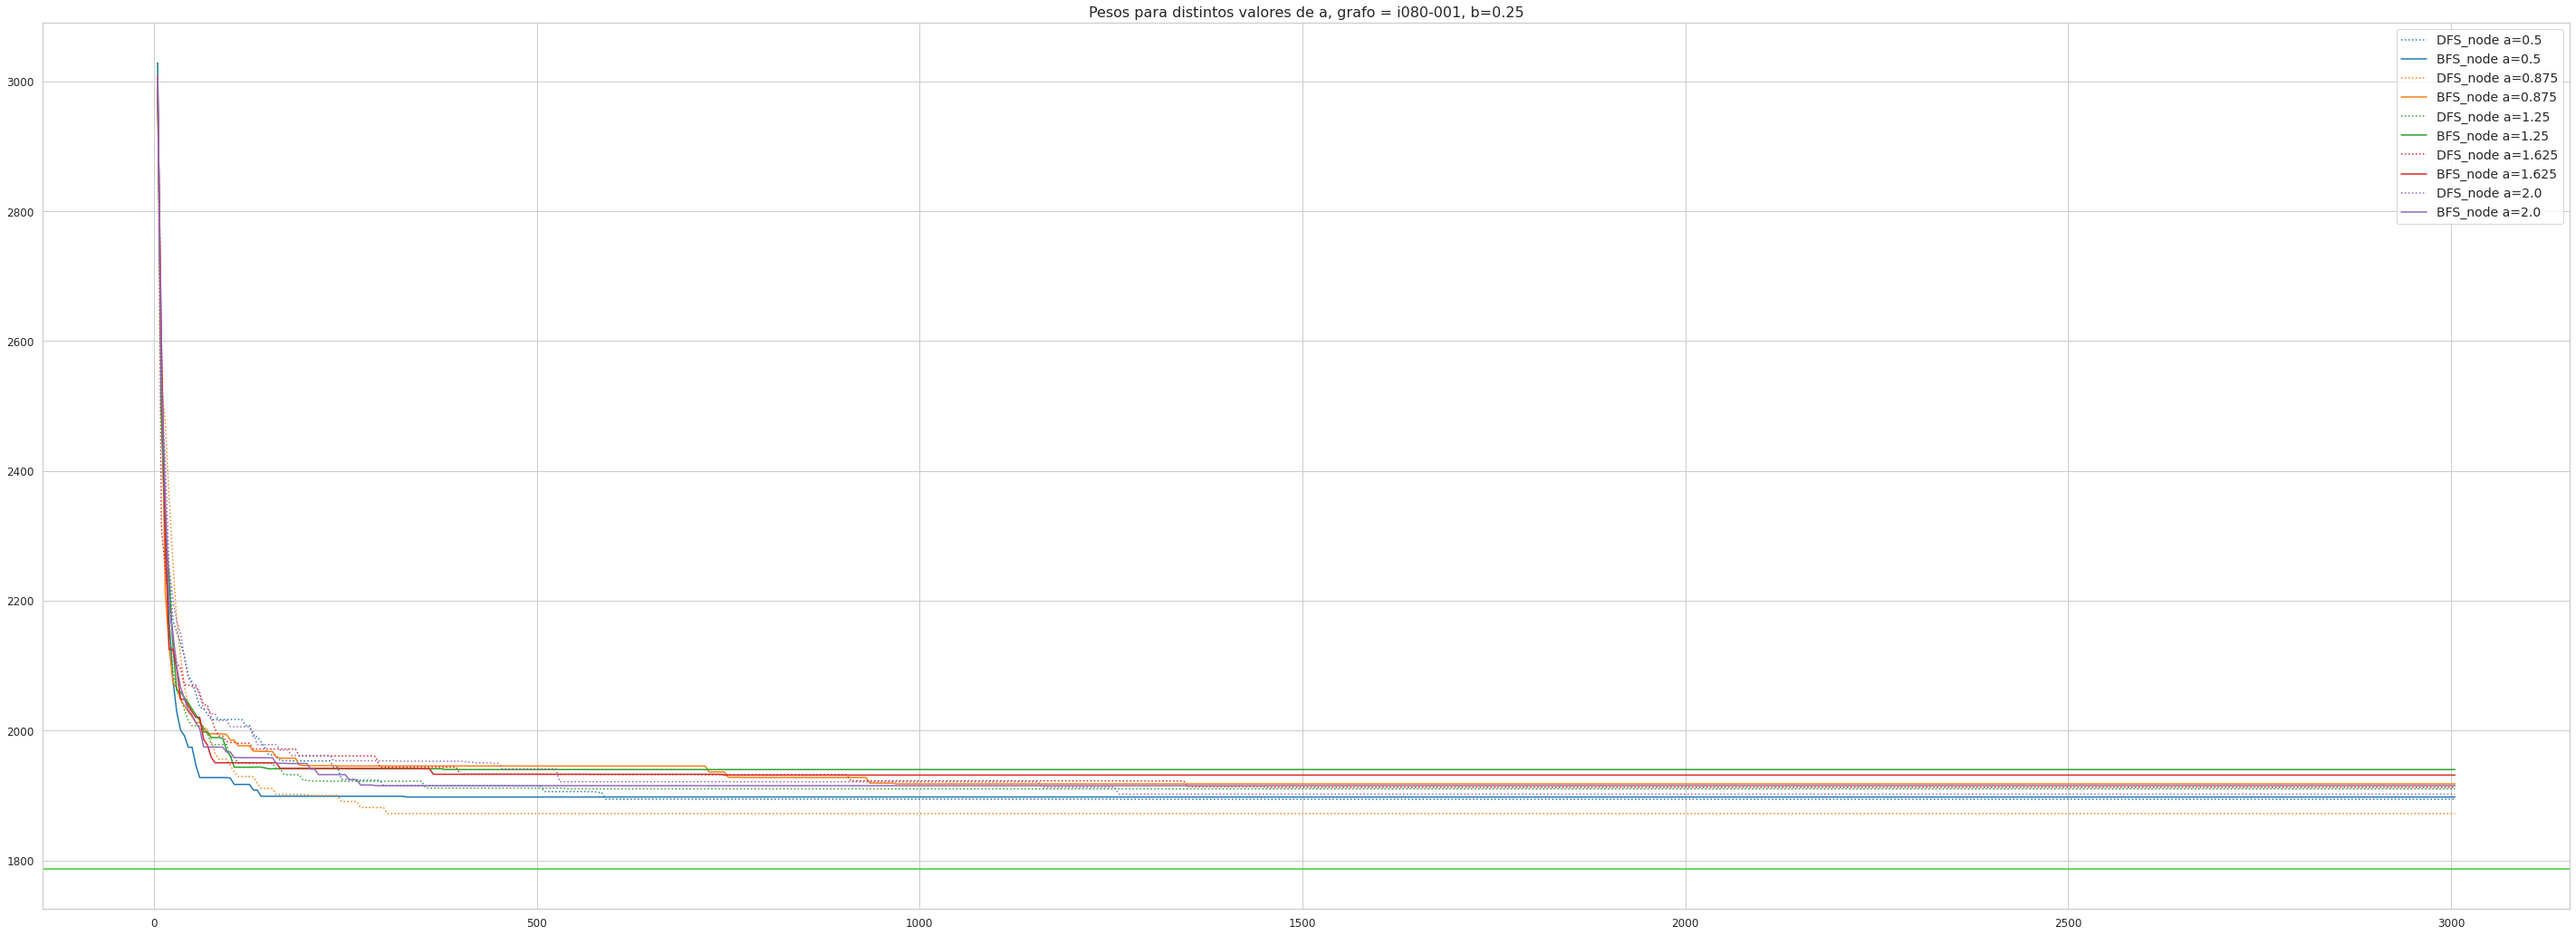

In [67]:
b = 0.25
plot_a(grafo_result,a_values,b,unif='mean');

In [68]:
def plot_b(grafo_result,b_values,a,unif='mean',log=False):
    # unif: 'mean' (str) or index (int)
    fig, ax = plt.subplots(1, 1, figsize=(25*2, 18))
    N = len(grafo_result.weight_avg[methods[0]][a_values[0]][b_values[0]])
    Ns = [i*params['save_rate'] for i in range(N)]
    for j, b in enumerate(b_values):
        if unif=='mean':
            values_dfs = grafo_result.weight_avg['DFS_node'][a][b][1:]
            values_bfs = grafo_result.weight_avg['BFS_node'][a][b][1:]
        else:
            values_dfs = grafo_result.weight_cm['DFS_node'][a][b][unif][1:]
            values_bfs = grafo_result.weight_cm['BFS_node'][a][b][unif][1:]
        ax.plot(Ns[1:], values_dfs, color=tab_c[j], label='DFS_node b={}'.format(a), linestyle='dotted')
        ax.plot(Ns[1:], values_bfs, color=tab_c[j], label='BFS_node b={}'.format(a), linestyle='solid')
    ax.legend()
    ax.axhline(y=grafo_result.opt, color="limegreen")
    ax.set_title('Pesos para distintos valores de b, grafo = {}, a={}'.format(grafo_result.id,a))
    if log:
        ax.set_yscale('log')

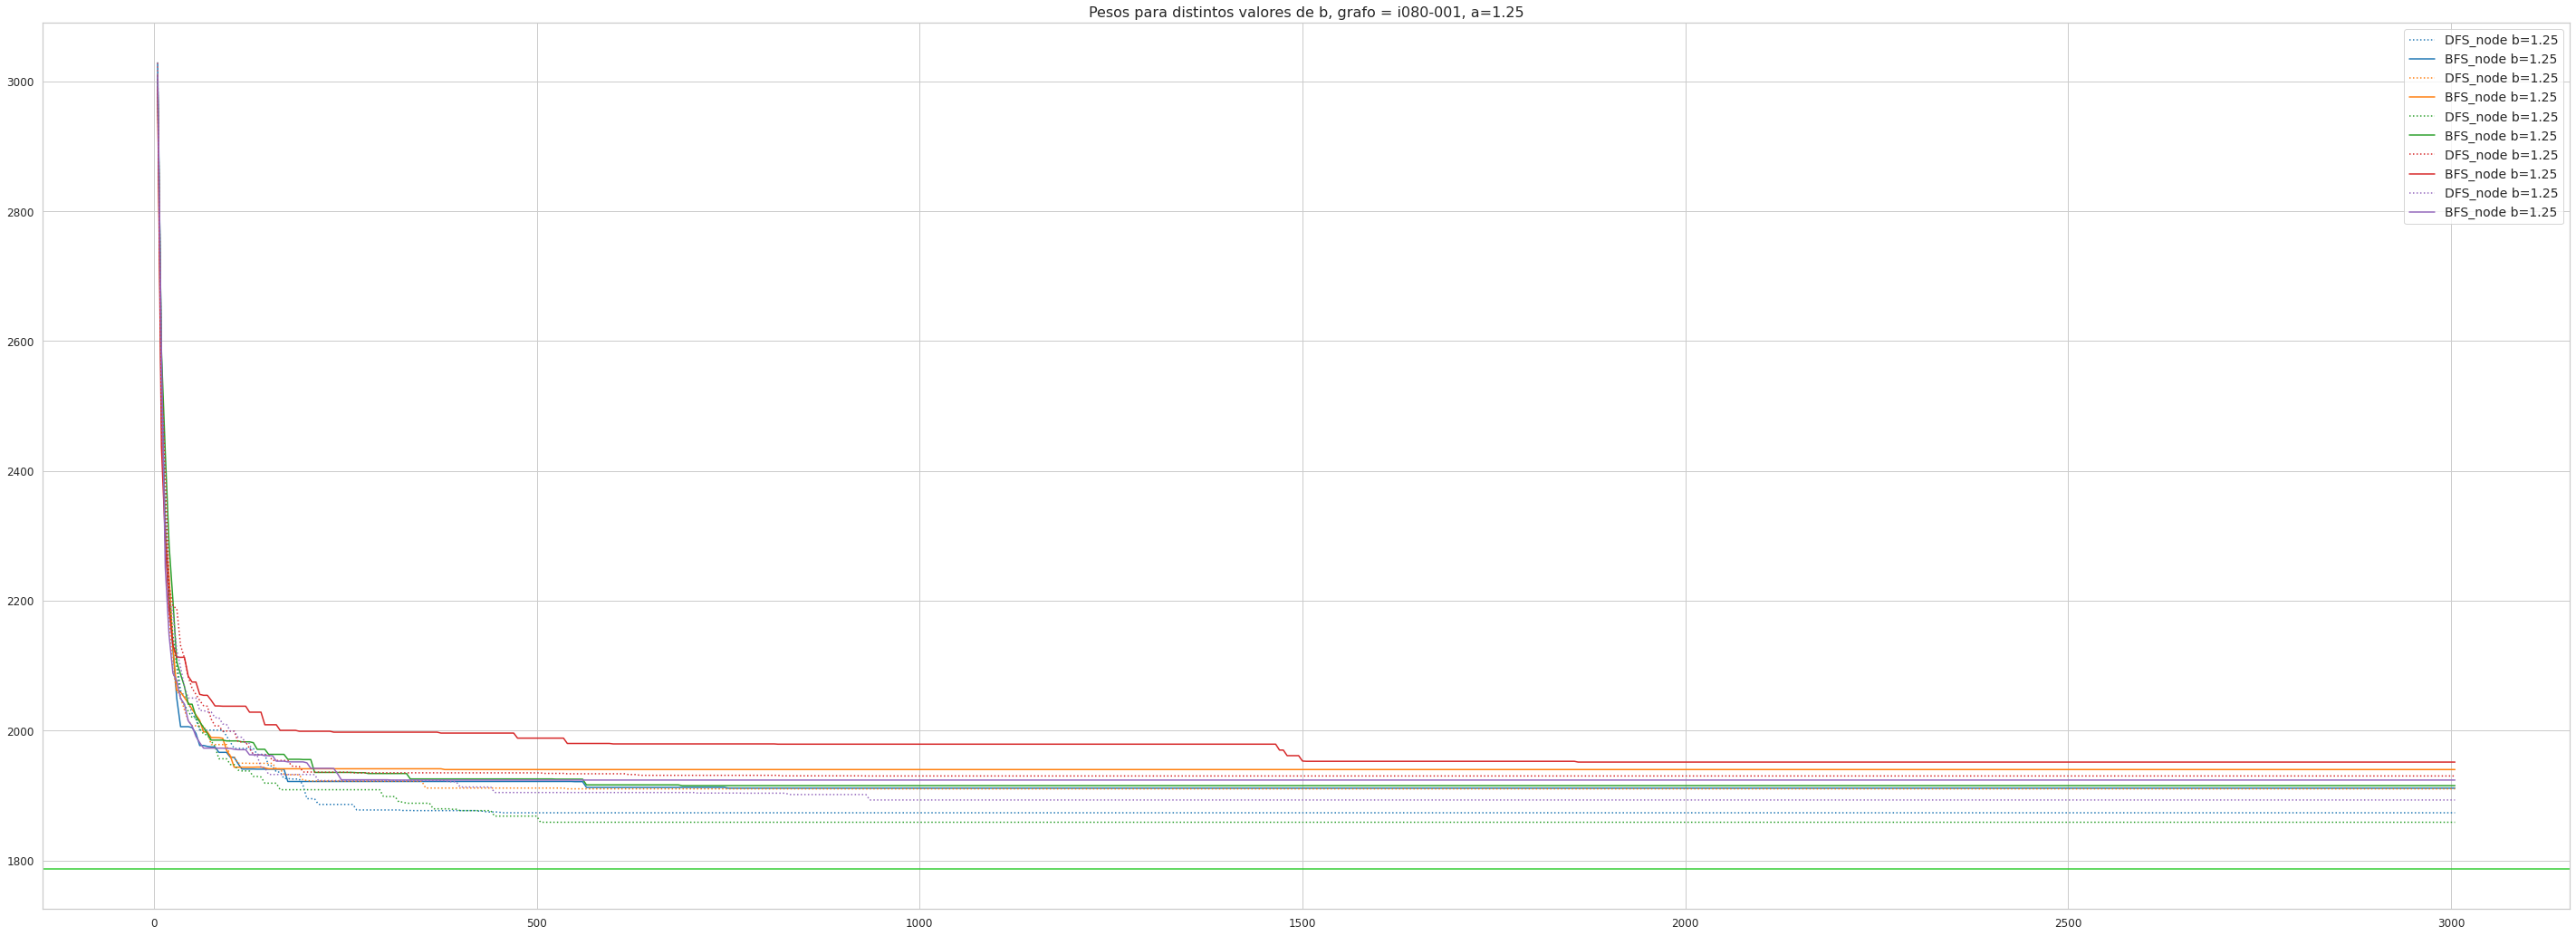

In [69]:
a = 1.25
plot_b(grafo_result,b_values,a);

In [70]:
def plot_ab_uniforms(grafo_result,a,b,interval=None,log=False):
    # interval: None, 'std' or 'minmax'
    fig, ax = plt.subplots(1, 1, figsize=(25*2, 18))
    N = len(grafo_result.weight_avg[methods[0]][a_values[0]][b_values[0]])
    Ns = [i*params['save_rate'] for i in range(N)]
    if interval=='std':
        print('uwu')
    elif interval=='minmax':
        print('owo')
    else:
        for l in range(grafo_result.len_U):
            values_dfs = grafo_result.weight_cm['DFS_node'][a][b][l][1:]
            values_bfs = grafo_result.weight_cm['BFS_node'][a][b][l][1:]
            ax.plot(Ns[1:], values_dfs, color=tab_c[l], label='DFS_node unif={}'.format(l), linestyle='dotted')
            ax.plot(Ns[1:], values_bfs, color=tab_c[l], label='BFS_node unif={}'.format(l), linestyle='solid')
    ax.legend()
    ax.axhline(y=grafo_result.opt, color="limegreen")
    ax.set_title('Pesos para distintas uniformes, grafo = {}, a={}, b={}'.format(grafo_result.id,a,b))
    if log:
        ax.set_yscale('log')

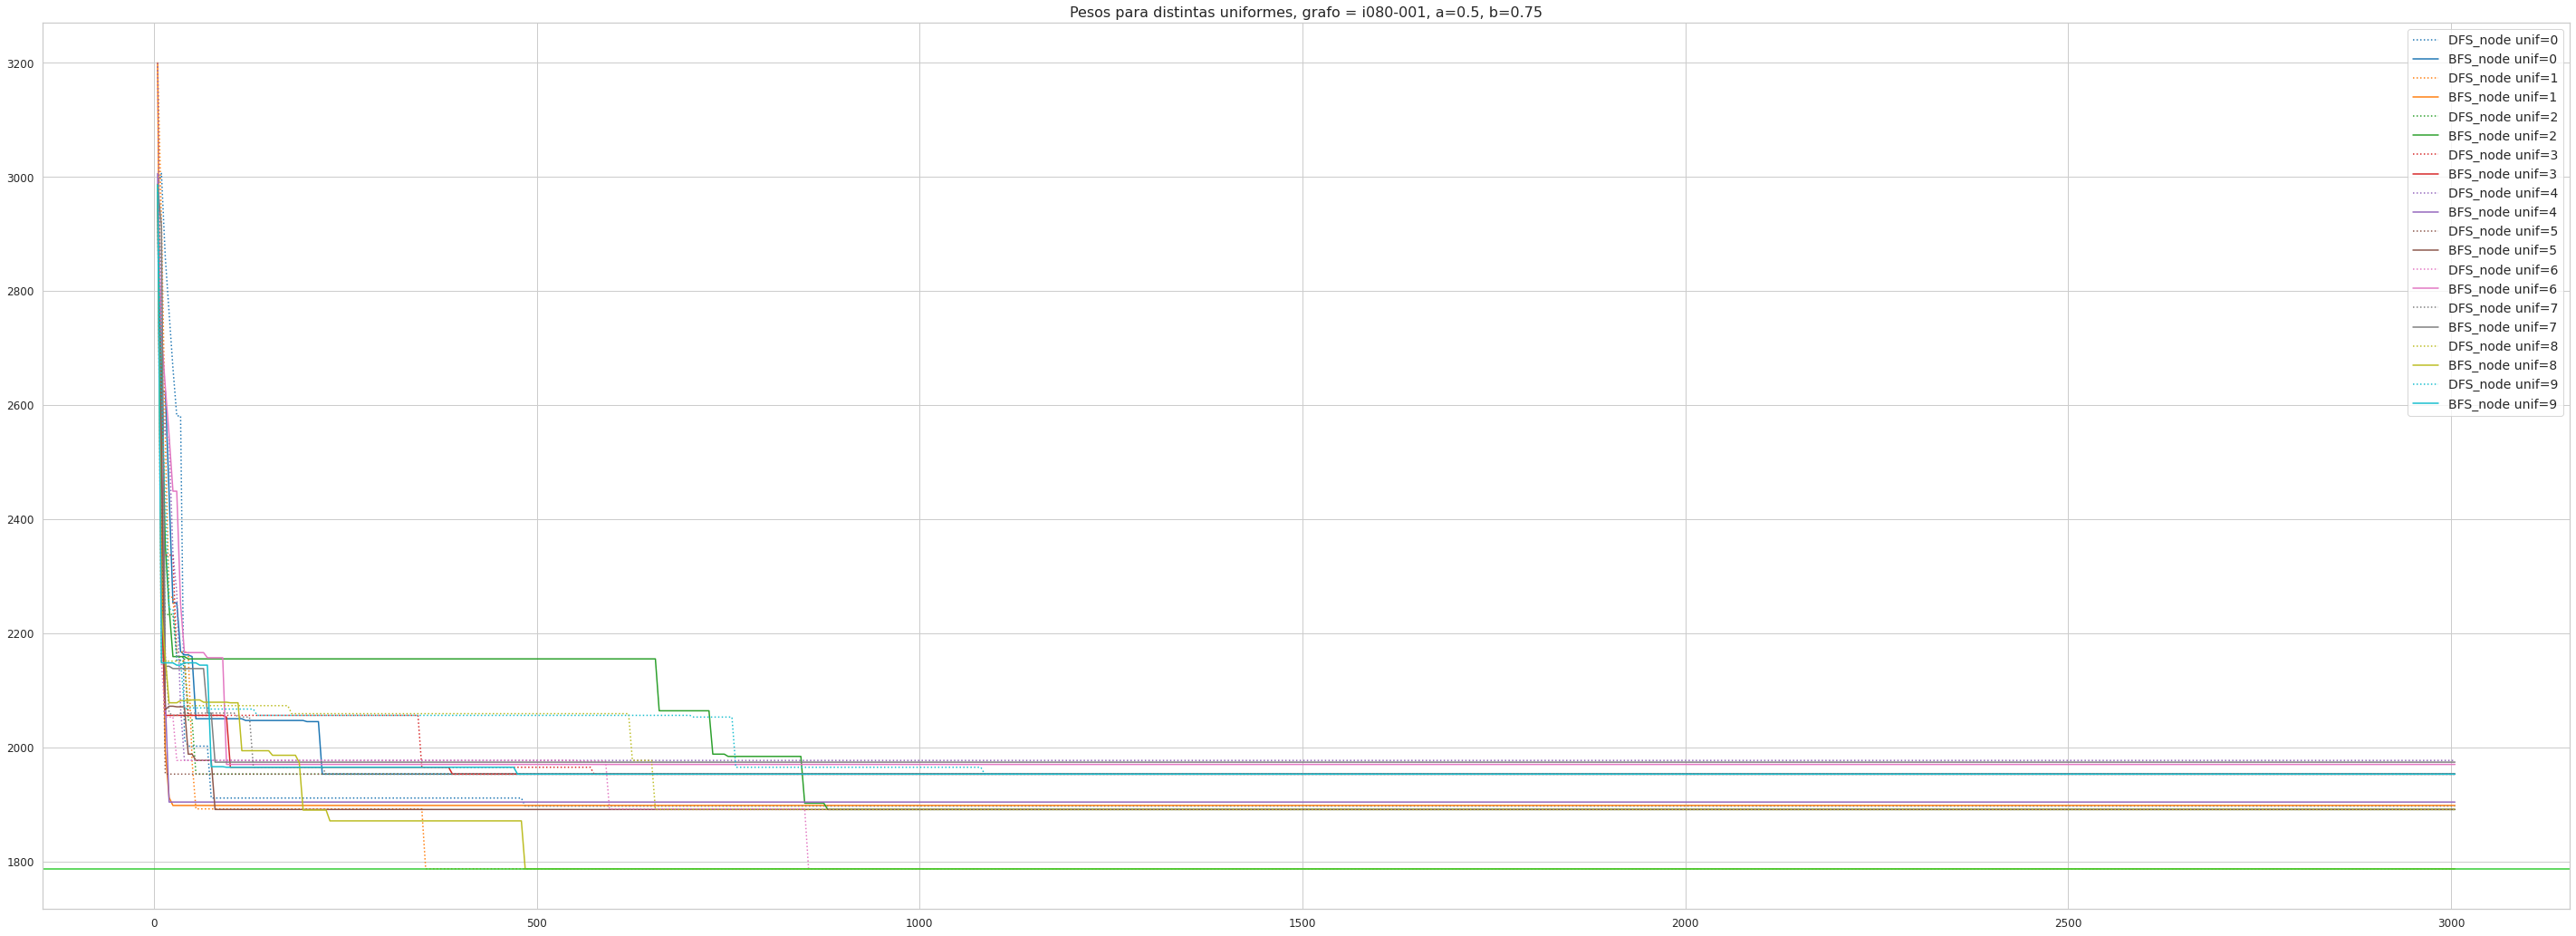

In [72]:
a = 0.5
b = 0.75
plot_ab_uniforms(grafo_result,a,b);

---

**Falta actualizar**

In [15]:
def plot_ab_grid_single_method(grafo_obj,metodo,a_values,b_values):
    matrix = np.zeros((len(a_values),len(b_values)))
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            matrix[i][j] = grafo_obj.weight_final[metodo][a][b] - grafo_obj.opt
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(8, 6))
        ax = sns.heatmap(matrix, square=True,xticklabels=a_values, vmax=350,
                         vmin=0, yticklabels=b_values, linewidths=.5)
        plt.title('Error para valores de a y b, grafo: {},, metodo={}'.format(grafo_result.id,metodo))
        plt.show()

In [16]:
# plot_ab_grid_single_method(grafo_result,'DFS_node',a_values,b_values)
# plot_ab_grid_single_method(grafo_result,'BFS_node',a_values,b_values)

In [52]:
def plot_ab_grid(grafo_obj,metodos,a_values,b_values,fig=None,ax=None):
    if not fig and not ax:
        fig, (ax1, ax2, axcb) = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1,1,0.08]})
    else:
        ax1, ax2, axcb = ax
    ax1.get_shared_y_axes().join(ax2)
    matrix1 = np.zeros((len(a_values),len(b_values)))
    matrix2 = np.zeros((len(a_values),len(b_values)))
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            matrix1[i][j] = grafo_obj.weight_final[metodos[0]][a][b] - grafo_obj.opt
            matrix2[i][j] = grafo_obj.weight_final[metodos[1]][a][b] - grafo_obj.opt
    avg1 = np.mean(matrix1)
    avg2 = np.mean(matrix2)
    with sns.axes_style("white"):
        g1 = sns.heatmap(matrix1, square=True, xticklabels=a_values, yticklabels=b_values, vmax=350,
                         vmin=0, cbar=False, linewidths=.5, ax=ax1)
        g2 = sns.heatmap(matrix2, square=True, xticklabels=a_values, yticklabels=b_values, vmax=350,
                         vmin=0, linewidths=.5, ax=ax2, cbar_ax=axcb)
        v, e, t = int(grafo_obj.size), int(grafo_obj.length), len(grafo_obj.terminals)
        fig.suptitle('Error para valores de a y b, grafo: {}, |V|={}, |E|={}, |T|={}'.format(grafo_obj.id,v,e,t))
        ax1.set_title('Metodo {}'.format(metodos[0]))
        ax2.set_title('Metodo {}'.format(metodos[1]))
        #plt.show()
    ax1.set(xlabel='a', ylabel='b')
    ax2.set(xlabel='a')
    return ax1, ax2, axcb, avg1, avg2

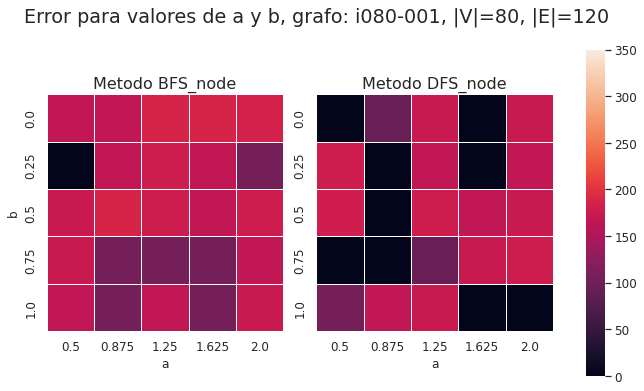

In [18]:
plot_ab_grid(grafo_result,methods,a_values,b_values);

---

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
import time

methods = ['BFS_node','DFS_node']
a_values = grid_search['a']
b_values = grid_search['b']

In [20]:
%%time
result_grafos = {}
for grafo in stp_names:
    # sacar stp
    result_grafos[grafo] = grafo_resultado(grafo)
    result_grafos[grafo].get_results(methods)
    result_grafos[grafo].compute_weight_cm()

CPU times: user 13.1 s, sys: 102 ms, total: 13.2 s
Wall time: 13.3 s


In [45]:
def densidad(grafo_obj):
    v = grafo_obj.size
    e = grafo_obj.length
    # grado = e/v
    # return 2*e/v*(v-1)
    return len(grafo_obj.terminals)

# print(densidad(result_grafos['i080-221.stp']))
densidades = {}
for grafo in stp_names:
    densidades[grafo] = densidad(result_grafos[grafo])

In [46]:
sorted(densidades.items(), key=lambda x: x[1], reverse=False)

[('i080-001.stp', 6),
 ('i080-011.stp', 6),
 ('i080-021.stp', 6),
 ('i080-031.stp', 6),
 ('i080-041.stp', 6),
 ('i080-101.stp', 8),
 ('i080-111.stp', 8),
 ('i080-121.stp', 8),
 ('i080-131.stp', 8),
 ('i080-141.stp', 8),
 ('i080-201.stp', 16),
 ('i080-211.stp', 16),
 ('i080-221.stp', 16),
 ('i080-231.stp', 16),
 ('i080-241.stp', 16),
 ('i080-301.stp', 20),
 ('i080-311.stp', 20),
 ('i080-321.stp', 20),
 ('i080-331.stp', 20),
 ('i080-341.stp', 20)]

<IPython.core.display.Javascript object>


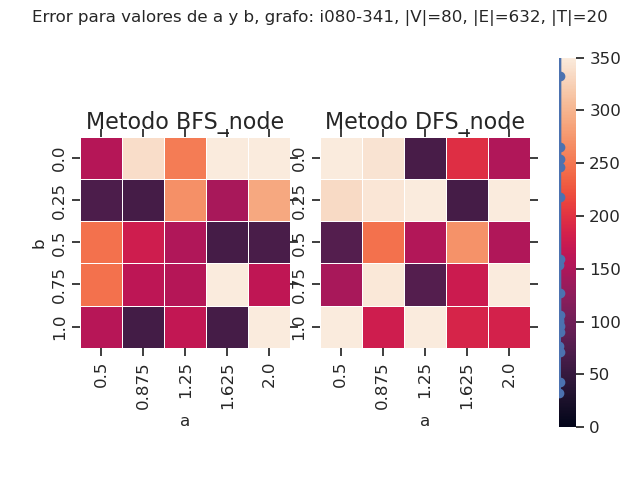

In [53]:
sleep = 1 # segundo

fig, (ax1, ax2, axcb) = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1,1,0.08]})
ax1.get_shared_y_axes().join(ax2)
plt.ion()
fig.show()
fig.canvas.draw()

dic_avg = {}

for g_id in sorted(densidades.items(), key=lambda x: x[1], reverse=False):  # result_grafos.keys():
    g_id = g_id[0]
    ax1.clear()
    ax2.clear()
    axcb.clear()
    ax1, ax2, axcb, avg1, avg2 = plot_ab_grid(result_grafos[g_id],methods,a_values,b_values,fig,(ax1, ax2, axcb))
    dic_avg[g_id] = (avg1, avg2)
    fig.canvas.draw()
    time.sleep(sleep)

<IPython.core.display.Javascript object>


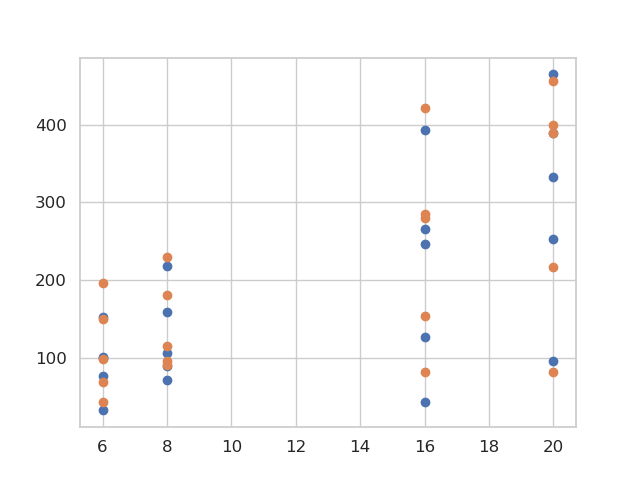

In [57]:
plt.scatter([g_id[1] for g_id in sorted(densidades.items(), key=lambda x: x[1], reverse=False)],[dic_avg[g_id[0]][1] for g_id in sorted(densidades.items(), key=lambda x: x[1], reverse=False)])
plt.scatter([g_id[1] for g_id in sorted(densidades.items(), key=lambda x: x[1], reverse=False)],[dic_avg[g_id[0]][0] for g_id in sorted(densidades.items(), key=lambda x: x[1], reverse=False)])

<IPython.core.display.Javascript object>


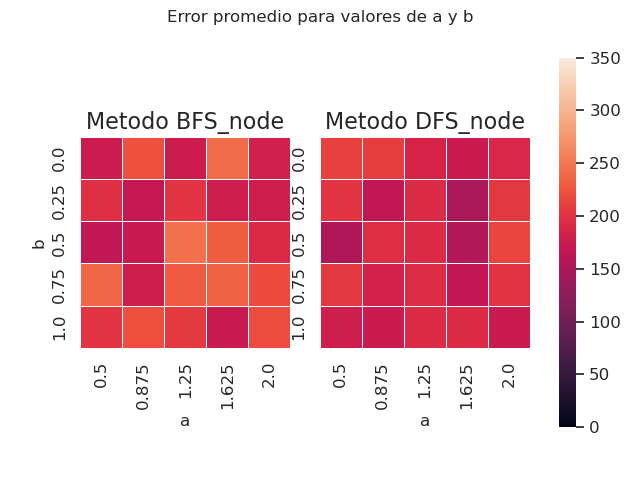

In [22]:
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1,1,0.08]})
ax1.get_shared_y_axes().join(ax2)

matrix1 = np.zeros((len(a_values),len(b_values)))
matrix2 = np.zeros((len(a_values),len(b_values)))
for g_id in result_grafos.keys():
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            matrix1[i][j] += result_grafos[g_id].weight_final[methods[0]][a][b] - result_grafos[g_id].opt
            matrix2[i][j] += result_grafos[g_id].weight_final[methods[1]][a][b] - result_grafos[g_id].opt
matrix1, matrix2 = matrix1/len(stp_names), matrix2/len(stp_names)

with sns.axes_style("white"):
    g1 = sns.heatmap(matrix1, square=True, xticklabels=a_values, yticklabels=b_values, vmax=350,
                     vmin=0, cbar=False, linewidths=.5, ax=ax1)
    g2 = sns.heatmap(matrix2, square=True, xticklabels=a_values, yticklabels=b_values, vmax=350,
                     vmin=0, linewidths=.5, ax=ax2, cbar_ax=axcb)
    fig.suptitle('Error promedio para valores de a y b')
    ax1.set_title('Metodo {}'.format(methods[0]))
    ax2.set_title('Metodo {}'.format(methods[1]))
ax1.set(xlabel='a', ylabel='b')
ax2.set(xlabel='a');

---